# SIRD Model

Basic SIRD model for Indonesia Covid 
(data until 20200412) using PSO optimization

![SIRD](../images/Scheme-of-Susceptible-Infectious-Recovered-Death-SIRD-Model-Boxes-represent.png)

In [1]:
PATH_DATA = '../data/raw/'
PATH_DATA_INTERIM = '../data/interim/'
PATH_SRC='../src/'
PATH_IMG='../images/'

In [2]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [3]:
import pandas as pd
import scipy.integrate as spi
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt
import pyswarms as ps
import sys

sys.path.insert(1, PATH_SRC)
from covid_model import sird_model, pso_sird

In [4]:
## Assumption
NUMB_OF_POPS=200000000
CURR_DATE='20200412'

## Get The Data

Getting the data and do the summary

In [5]:
col_use=['Sus','Inf','Rec','Dea']
col_use_pred=[x+'_pred' for x in col_use]

In [6]:
## Get The Raw Data
df_daily0=pd.read_csv(PATH_DATA+'20200404_DailyCase_ID.csv')
df_daily1=pd.read_csv(PATH_DATA+CURR_DATE+'_DailyCase_ID.csv')
df_daily=pd.concat([df_daily0,df_daily1]).drop_duplicates()
df_daily=df_daily.reset_index()
del df_daily['index']
df_daily=df_daily.fillna(0)

## Get the compartment value
df_daily['Rec']=df_daily['Sembuh (baru)'].cumsum()
df_daily['Dea']=df_daily['Meninggal (baru)'].cumsum()
df_daily['Inf']=df_daily['Kasus (Kumulatif)']-df_daily['Rec']-df_daily['Dea']
df_daily['Sus']=NUMB_OF_POPS-df_daily['Inf']-df_daily['Rec']-df_daily['Dea']
df_daily.to_csv(PATH_DATA_INTERIM+CURR_DATE+'_DailyCase_ID_SIRD.csv',index=False)

## Standardized it by divide it by population number
df_daily_sird=df_daily[col_use]/NUMB_OF_POPS
df_daily_sird['weight']=2

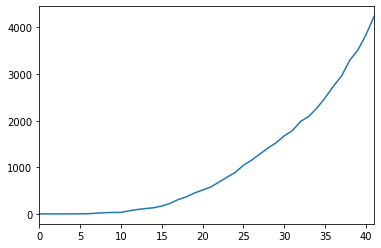

In [7]:
df_daily['Kasus (Kumulatif)'].plot()

In [8]:
df_daily_sird

,Sus,Inf,Rec,Dea,weight
0,1.000000,1.000000e-08,0.000000e+00,0.000000e+00,2
1,1.000000,1.000000e-08,0.000000e+00,0.000000e+00,2
2,1.000000,1.000000e-08,0.000000e+00,0.000000e+00,2
3,1.000000,1.000000e-08,0.000000e+00,0.000000e+00,2
4,1.000000,2.000000e-08,0.000000e+00,0.000000e+00,2
5,1.000000,2.000000e-08,0.000000e+00,0.000000e+00,2
6,1.000000,3.000000e-08,0.000000e+00,0.000000e+00,2
7,1.000000,9.500000e-08,0.000000e+00,0.000000e+00,2
8,1.000000,1.350000e-07,0.000000e+00,0.000000e+00,2
9,1.000000,1.500000e-07,1.000000e-08,1.000000e-08,2


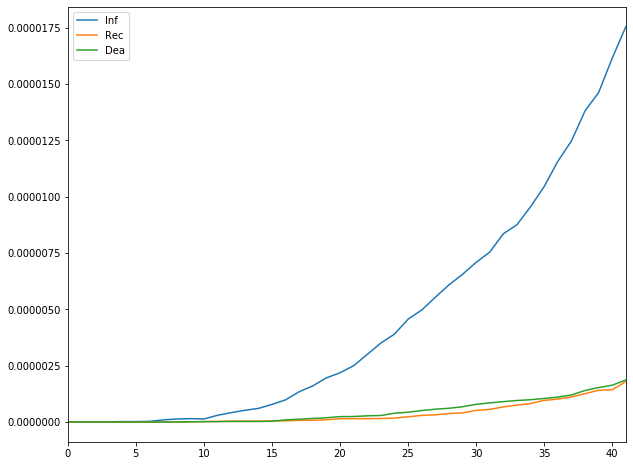

In [9]:
df_daily_sird[['Inf','Rec','Dea']].plot(figsize=(10,8))

## Tuning Parameter SIRD Model

The tuning parameter is more focus on I and R.. meanwhile the newest data is more influence the model than the last one.. (using weight)

In [10]:
# param_b,param_r,param_m

In [11]:
## Summary
## First 23 day --> [0.30421772, 0.01571879, 0.02715623] (1.13785449363775)
## First 25 day --> [0.2942096 , 0.01569591, 0.02679847] (2.7496582873743516)
## First 27 day --> [0.282616  , 0.01432964, 0.02584207] (5.365068009)
## First 28 day --> [0.27636661, 0.01389041, 0.02523562]
## First 34 day --> [0.25272228, 0.01689525, 0.02514914] (61.60118585319816)
## First 42 day --> [0.22767359, 0.02074732, 0.0213562 ] (255.07607154442)

In [12]:
df_daily_sird.shape

(42, 5)

### Training All Data

In [13]:
## all current data
df_daily0=df_daily_sird.copy()
prt=int(len(df_daily0)/5)+1
weight_ls=[3.5]*prt+[3]*prt+[0.3]*prt+[0.1]*prt+[0.05]*prt
weight_ls2=weight_ls[:len(df_daily0)]
weight_ls2.sort()
df_daily0['weight']=weight_ls2

In [14]:
df_daily0.tail()

,Sus,Inf,Rec,Dea,weight
37,0.999985,0.000012,0.000001,0.000001,3.5
38,0.999984,0.000014,0.000001,0.000001,3.5
39,0.999982,0.000015,0.000001,0.000002,3.5
40,0.999981,0.000016,0.000001,0.000002,3.5
41,0.999979,0.000018,0.000002,0.000002,3.5


In [19]:
all_param,cost_value=pso_sird(df0=df_daily0,population=NUMB_OF_POPS)

2020-04-12 22:08:52,165 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.15, 'c2': 0.95, 'w': 0.25}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=356
2020-04-12 22:09:11,000 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 356.3698711517976, best pos: [0.29737067 0.02528526 0.08935134]
2020-04-12 22:09:11,018 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.15, 'c2': 0.95, 'w': 0.25}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=660   
2020-04-12 22:09:29,629 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 660.1418585035774, best pos: [0.40864025 0.08026195 0.15228144]
2020-04-12 22:09:29,648 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.15, 'c2': 0.95, 'w': 0.25}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=255
2020-04-12 22:09:55,263 - pyswarms.single.global_best - INFO - Optimization finished | best cost:

In [20]:
all_param,cost_value

(array([0.25916641, 0.03373441, 0.04105927]), 255.10499511004957)

In [21]:
# all_param=[0.27808851,0.0143996,0.02582378] # --> (8.614889469)
all_param = [0.22767359, 0.02074732, 0.0213562 ]

In [22]:
## Predict
T_start = 0.0
T_inc=1.0
# T_end = 23+4
T_end = 30*6

I0=2/NUMB_OF_POPS
S0=1-I0
INPUT = (S0, I0, 0.0, 0.0)
col_use_pred=[x+'_pred' for x in col_use]
T_range = np.arange(T_start, T_end+T_inc, T_inc)
RES = sird_model(all_param,INPUT,T_range)
df_sird_pred=pd.DataFrame(RES,columns=['Sus_pred','Inf_pred','Rec_pred','Dea_pred'])*NUMB_OF_POPS

In [23]:
data_check=pd.concat([df_daily[['Inf','Rec','Dea']],df_sird_pred[['Inf_pred','Rec_pred','Dea_pred']]],axis=1)
error_Inf=np.abs(data_check[26-prt:26]['Inf']-data_check[26-prt:26]['Inf_pred']).mean()
error_Rec=np.abs(data_check[26-prt:26]['Rec']-data_check[26-prt:26]['Rec_pred']).mean()
data_check['Inf_pred_max']=data_check['Inf_pred']+error_Inf
data_check['Inf_pred_min']=data_check['Inf_pred']-error_Inf
data_check['Rec_pred_max']=data_check['Rec_pred']+error_Rec
data_check['Rec_pred_min']=data_check['Rec_pred']-error_Rec
data_check[21:30]

,Inf,Rec,Dea,Inf_pred,Rec_pred,Dea_pred,Inf_pred_max,Inf_pred_min,Rec_pred_max,Rec_pred_min
21,500.0,30.0,49.0,104.445400,11.453724,11.789861,533.184530,-324.293730,26.579610,-3.672161
22,600.0,30.0,55.0,126.046759,13.868827,14.275841,554.785889,-302.692371,28.994712,-1.257059
23,701.0,31.0,58.0,151.866207,16.755526,17.247257,580.605337,-276.872923,31.881411,1.629640
24,780.0,35.0,78.0,183.792556,20.324997,20.921483,612.531686,-244.946574,35.450883,5.199112
25,913.0,46.0,87.0,221.913999,24.587102,25.308670,650.653129,-206.825131,39.712988,9.461216
26,994.0,59.0,102.0,267.101672,29.639236,30.509071,695.840801,-161.637458,44.765122,14.513350
27,1107.0,64.0,114.0,322.379575,35.819495,36.870704,751.118705,-106.359555,50.945380,20.693609
28,1217.0,75.0,122.0,388.324371,43.192351,44.459935,817.063501,-40.414758,58.318237,28.066466
29,1311.0,81.0,136.0,468.900760,52.201077,53.733043,897.639890,40.161631,67.326963,37.075191


In [24]:
date_1 = dt.datetime.strptime("2020-03-02", "%Y-%m-%d")
all_date=[date_1 + dt.timedelta(days=int(i)) for i in range(T_end+1)]
df_sird_pred.index=all_date

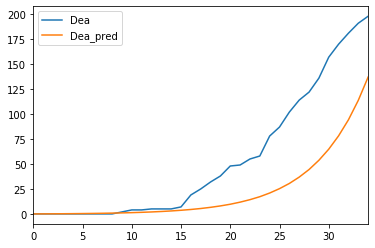

In [26]:
check_col='Dea'
data_check[:35][[check_col,check_col+'_pred']].plot()

In [27]:
# df_sird_pred['Dea_pred'].max()

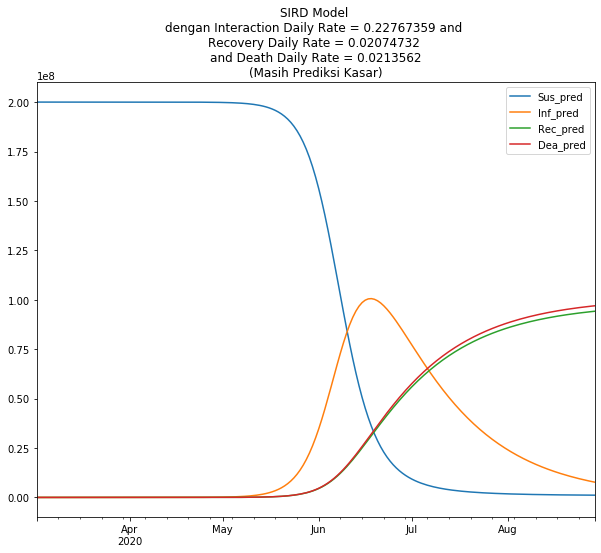

In [28]:
# df_sird_pred[['Inf_pred','Rec_pred','Dea_pred']].plot(figsize=(10,8))
txt='SIRD Model \ndengan Interaction Daily Rate = '+str(all_param[0])+' and \nRecovery Daily Rate = '+str(
            all_param[1])+' \nand Death Daily Rate = '+str(all_param[2])+'\n(Masih Prediksi Kasar)'
sird_plot =df_sird_pred.plot(figsize=(10,8),title=txt)
fig = sird_plot.get_figure()
fig.savefig(PATH_IMG+CURR_DATE+"sird_result.png")

## Rate Changes

In [29]:
## Summary
Param_changes=[[23, 0.30421772, 0.01571879, 0.02715623],
[25,0.2942096 , 0.01569591, 0.02679847], 
[27,0.282616  , 0.01432964, 0.02584207],
[28,0.27636661, 0.01389041, 0.02523562],
[34,0.25272228, 0.01689525, 0.02514914],
[42,0.22767359, 0.02074732, 0.0213562 ]]

df_Param_changes=pd.DataFrame(Param_changes,columns=['Days','Contact Daily Rate','Recovery Daily Rate','Death Daily Rate'])
df_Param_changes.index=df_Param_changes.Days
del df_Param_changes['Days']


In [30]:
df_Param_changes

,Contact Daily Rate,Recovery Daily Rate,Death Daily Rate
Days,,,
23,0.304218,0.015719,0.027156
25,0.294210,0.015696,0.026798
27,0.282616,0.014330,0.025842
28,0.276367,0.013890,0.025236
34,0.252722,0.016895,0.025149
42,0.227674,0.020747,0.021356


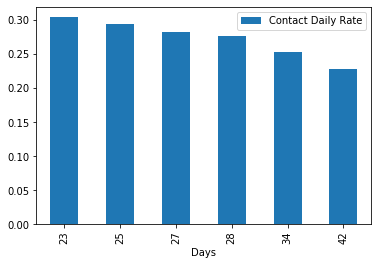

In [31]:
df_Param_changes[['Contact Daily Rate']].plot(kind='bar')

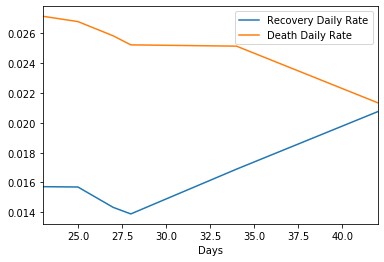

In [32]:
df_Param_changes[['Recovery Daily Rate','Death Daily Rate']].plot()

## Conclusion

...